In [ ]:
from utils.VCA import *
import numpy as np
import torch.nn as nn
import torch
import os
import random
import scipy.io as io
import torch.nn.functional as F
from utils.dealmat import readmat
L = 173
P = 3
nr1 = 150
nc1 = 110
T = 6

End_path = './data/M1.mat'
M0 = io.loadmat(End_path)
M0 = torch.tensor(M0['M0']).float().to('cuda:0')


def seed_everything(seed=3407):
    '''
    set seed
    :param seed:
    :param device:
    :return:
    '''
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # some cudnn methods can be random even after fixing the seed unless you tell it to be deterministic
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything()

def endmember(HSI):
    E_torch, _ = vca(HSI, P, snr_input=30)
    return E_torch

def deal_end(end):
    end = end.unsqueeze(2).unsqueeze(3).float()
    return end

def np_to_torch(img_np):
    '''Converts image in numpy.array to torch.Tensor.

    From C x W x H [0..1] to  C x W x H [0..1]
    '''
    img_np.astype(np.float32)
    return torch.from_numpy(img_np)

def End_deal(path, device):
    HSI = readmat(path=path)
    HSI_1 = HSI[:, 0, :, :, :].reshape(L, -1)
    HSI_2 = HSI[:, 1, :, :, :].reshape(L, -1)
    HSI_3 = HSI[:, 2, :, :, :].reshape(L, -1)
    HSI_4 = HSI[:, 3, :, :, :].reshape(L, -1)
    HSI_5 = HSI[:, 4, :, :, :].reshape(L, -1)
    HSI_6 = HSI[:, 5, :, :, :].reshape(L, -1)
    
    Endmember_1 = endmember(HSI_1)
    Endmember_2 = endmember(HSI_2)
    Endmember_3 = endmember(HSI_3)
    Endmember_4 = endmember(HSI_4)
    Endmember_5 = endmember(HSI_5)
    Endmember_6 = endmember(HSI_6)
    
    Endmember_1 = np_to_torch(Endmember_1)
    Endmember_2 = np_to_torch(Endmember_2)
    Endmember_3 = np_to_torch(Endmember_3)
    Endmember_4 = np_to_torch(Endmember_4)
    Endmember_5 = np_to_torch(Endmember_5)
    Endmember_6 = np_to_torch(Endmember_6)
    
    Endmember_1 = Endmember_1.to(device)
    Endmember_2 = Endmember_2.to(device)
    Endmember_3 = Endmember_3.to(device)
    Endmember_4 = Endmember_4.to(device)
    Endmember_5 = Endmember_5.to(device)
    Endmember_6 = Endmember_6.to(device)

    # Endmember_1 = deal_end(Endmember_1)
    # Endmember_2 = deal_end(Endmember_2)
    # Endmember_3 = deal_end(Endmember_3)
    # Endmember_4 = deal_end(Endmember_4)
    # Endmember_5 = deal_end(Endmember_5)
    # Endmember_6 = deal_end(Endmember_6)

    Endmember_1[Endmember_1 < 0] = 0
    Endmember_2[Endmember_2 < 0] = 0
    Endmember_3[Endmember_3 < 0] = 0
    Endmember_4[Endmember_4 < 0] = 0
    Endmember_5[Endmember_5 < 0] = 0
    Endmember_6[Endmember_6 < 0] = 0

    HSI = HSI.to(device)
    return Endmember_1, Endmember_2, Endmember_3, Endmember_4, Endmember_5, Endmember_6, HSI

class SAD(nn.Module):
    def __init__(self, num_bands):
        super(SAD, self).__init__()
        self.num_bands = num_bands

    def forward(self, inp, target):
        input_norm = torch.sqrt(torch.bmm(inp.view(-1, 1, self.num_bands),
                                          inp.view(-1, self.num_bands, 1)))
        target_norm = torch.sqrt(torch.bmm(target.view(-1, 1, self.num_bands),
                                           target.view(-1, self.num_bands, 1)))

        summation = torch.bmm(inp.view(-1, 1, self.num_bands), target.view(-1, self.num_bands, 1))
        angle = torch.acos(summation / (input_norm * target_norm))

        return angle


def total_variation_loss(images):
    # 计算水平方向的梯度
    gradient_x = torch.abs(images[:, :, :, :-1] - images[:, :, :, 1:])
    # 计算垂直方向的梯度
    gradient_y = torch.abs(images[:, :, :-1, :] - images[:, :, 1:, :])
    # 计算时间方向的梯度
    gradient_t = torch.abs(images[:-1, :, :, :] - images[1:, :, :, :])
    # 计算总变差损失
    tv_loss = (torch.sum(gradient_x) + torch.sum(gradient_y) + torch.sum(gradient_t)) / (nr1 * nc1 * T)
    return tv_loss

class NonZeroClipper(object):
    def __call__(self, module):
        if hasattr(module, 'weight'):
            w = module.weight.data
            w.clamp_(1e-6, 1)

def Nuclear_norm(inputs):
    band, h, w = inputs.shape
    input = torch.reshape(inputs, (band, h*w))
    out = torch.norm(input, p='nuc')
    return out

def end_loss(HSI, End):
    End = End.cpu()
    O = torch.mean(HSI.reshape(L,nr1*nc1),1).reshape(L,1).cpu()
    B = torch.from_numpy(np.identity(P)).float()
    loss_end = torch.norm(torch.mm(End, B.view((P, P))) - O, 'fro')**2
    
    return loss_end.cuda()

class SparseKLloss(nn.Module):
    def __init__(self):
        super(SparseKLloss, self).__init__()

    def __call__(self, input, decay=4e-4):
        input = torch.sum(input, 0, keepdim=True)
        loss = Nuclear_norm(input)
        return decay*loss
    
class SAD(nn.Module):
    def __init__(self, num_bands):
        super(SAD, self).__init__()
        self.num_bands = num_bands

    def forward(self, inp, target):
        input_norm = torch.sqrt(torch.bmm(inp.view(-1, 1, self.num_bands),
                                          inp.view(-1, self.num_bands, 1)))
        target_norm = torch.sqrt(torch.bmm(target.view(-1, 1, self.num_bands),
                                           target.view(-1, self.num_bands, 1)))

        summation = torch.bmm(inp.view(-1, 1, self.num_bands), target.view(-1, self.num_bands, 1))
        angle = torch.acos(summation / (input_norm * target_norm))

        return angle

loss2 = SAD(L)

def sad_loss(out, HSI):
    # print(out.shape)
    # print(HSI.shape)  
    loss_sad_1 = loss2(out[0, :, :, :].contiguous().view(1, L, -1).transpose(1, 2),
                        HSI[0, 0, :, :, :].contiguous().view(1, L, -1).transpose(1, 2))
    loss_sad_1 = loss_sad_1[~torch.isnan(loss_sad_1)]
    loss_sad_1 = torch.sum(loss_sad_1)
    
    loss_sad_2 = loss2(out[1, :, :, :].contiguous().view(1, L, -1).transpose(1, 2),
                        HSI[0, 1, :, :, :].contiguous().view(1, L, -1).transpose(1, 2))
    loss_sad_2 = loss_sad_2[~torch.isnan(loss_sad_2)]
    loss_sad_2 = torch.sum(loss_sad_2)
    
    loss_sad_3 = loss2(out[2, :, :, :].contiguous().view(1, L, -1).transpose(1, 2),
                        HSI[0, 2, :, :, :].contiguous().view(1, L, -1).transpose(1, 2))
    loss_sad_3 = loss_sad_3[~torch.isnan(loss_sad_3)]
    loss_sad_3 = torch.sum(loss_sad_3)
    
    loss_sad_4 = loss2(out[3, :, :, :].contiguous().view(1, L, -1).transpose(1, 2),
                        HSI[0, 3, :, :, :].contiguous().view(1, L, -1).transpose(1, 2))
    loss_sad_4 = loss_sad_4[~torch.isnan(loss_sad_4)]
    loss_sad_4 = torch.sum(loss_sad_4)
    
    loss_sad_5 = loss2(out[4, :, :, :].contiguous().view(1, L, -1).transpose(1, 2),
                        HSI[0, 4, :, :, :].contiguous().view(1, L, -1).transpose(1, 2))
    loss_sad_5 = loss_sad_5[~torch.isnan(loss_sad_5)]
    loss_sad_5 = torch.sum(loss_sad_5)
    
    loss_sad_6 = loss2(out[5, :, :, :].contiguous().view(1, L, -1).transpose(1, 2),
                        HSI[0, 5, :, :, :].contiguous().view(1, L, -1).transpose(1, 2))
    loss_sad_6 = loss_sad_6[~torch.isnan(loss_sad_6)]
    loss_sad_6 = torch.sum(loss_sad_6)
    
    return loss_sad_1, loss_sad_2, loss_sad_3, loss_sad_4, loss_sad_5, loss_sad_6

input SNR = 30[dB]

... Select the projective proj.
input SNR = 30[dB]

... Select the projective proj.
input SNR = 30[dB]

... Select the projective proj.
input SNR = 30[dB]

... Select the projective proj.
input SNR = 30[dB]

... Select the projective proj.
input SNR = 30[dB]

... Select the projective proj.
Epoch: 0 | total loss: 0.2778 | reconstruction loss: 0.3614 | SAD loss: 0.1270 | loss_sparse: 0.0514 | end_loss: 0.5160
Epoch: 20 | total loss: 0.1629 | reconstruction loss: 0.1062 | SAD loss: 0.0855 | loss_sparse: 0.0514 | end_loss: 0.0174
Epoch: 40 | total loss: 0.1557 | reconstruction loss: 0.1011 | SAD loss: 0.0796 | loss_sparse: 0.0514 | end_loss: 0.0120
Epoch: 60 | total loss: 0.1490 | reconstruction loss: 0.0984 | SAD loss: 0.0733 | loss_sparse: 0.0514 | end_loss: 0.0190
Epoch: 80 | total loss: 0.1468 | reconstruction loss: 0.0986 | SAD loss: 0.0711 | loss_sparse: 0.0514 | end_loss: 0.0217
Epoch: 100 | total loss: 0.1442 | reconstruction loss: 0.0966 | SAD loss: 0.0689 | l

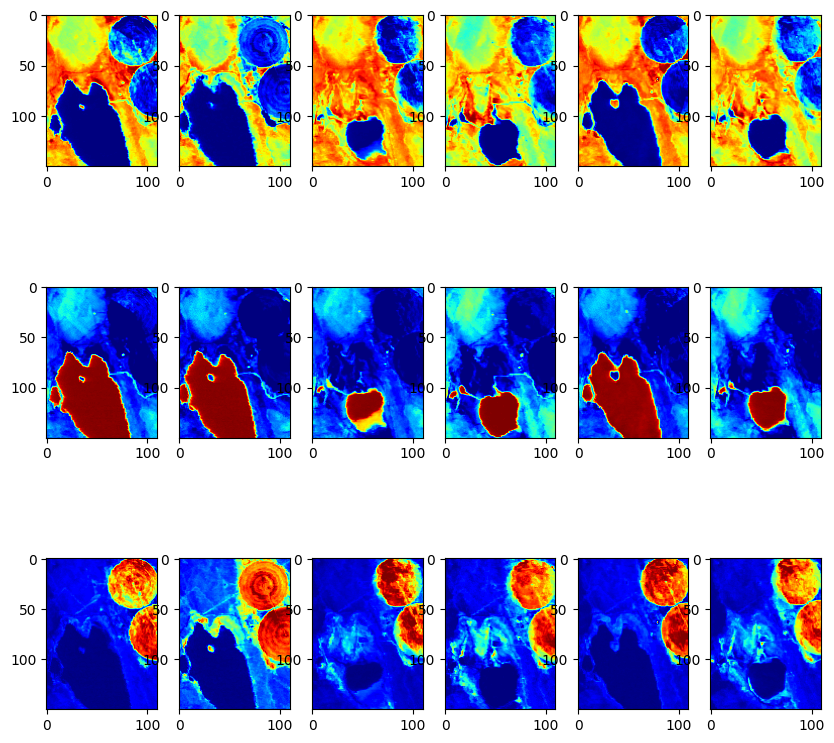

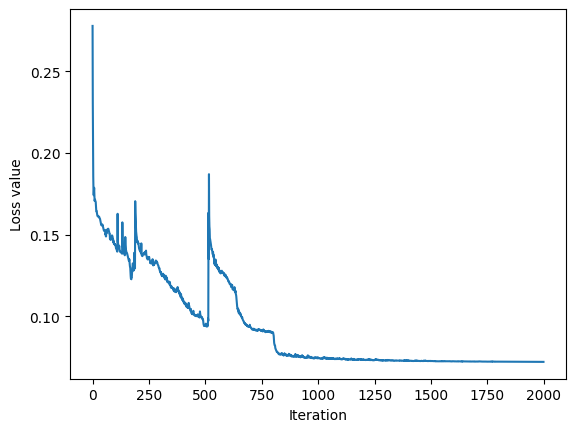

In [2]:
import torch
from utils.dealmat import *
from Muformer_pytorch.muformer_lake import MUFormer
import matplotlib.pyplot as plt
import torch.nn as nn
import time
from plot import plot_abundance
            
def main():
    path = './data/rd_tip_with_outliers_t5.mat'
    lr = 0.08
    weight_decay = 4e-5
    epoch = 2000
    L = 173
    device = 'cuda:0'
    T = 6
    nr1 = 150
    nc1 = 110
    P = 3
    beta = 0.25
    gamma = 0.99
    N = nr1 * nc1
    iter_rec, loss_rec, x_rec = list(), list(), list()
    train_losses = []
    order = (1, 2, 0)
    
    net = MUFormer(dim = 600,image_width = 110,image_height = 150,patch_size = 10,channels=L,
    num_frames = T,P = 3,depth = 2,heads = 8,dim_head =  60,attn_dropout = 0.1,ff_dropout = 0.1)
    
    Endmember_1, Endmember_2, Endmember_3, Endmember_4, \
    Endmember_5, Endmember_6, HSI = End_deal(path, device)
    
    model_dict = net.state_dict()
    model_dict['decoder1.0.weight'] = Endmember_1
    model_dict['decoder2.0.weight'] = Endmember_2
    model_dict['decoder3.0.weight'] = Endmember_3
    model_dict['decoder4.0.weight'] = Endmember_4
    model_dict['decoder5.0.weight'] = Endmember_5
    model_dict['decoder6.0.weight'] = Endmember_6
    net.load_state_dict(model_dict)
    
    net.apply(net.weights_init)
    net.to(device)
    loss1 = nn.MSELoss(reduction='mean')
    loss2 = SAD(L)
    

        
    criterionSparse = SparseKLloss()
    optim = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay, betas=(0.9, 0.999), eps=1e-8)  # Adamw   
    scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=40, gamma=0.92)
    apply_clamp_inst1 = NonZeroClipper()
    time_start = time.time()

    for iter in range(epoch):
        net.train()
        abu, out = net(HSI)
        re_loss1 = loss1(out[0, :, :, :], HSI[0, 0, :, :, :])
        re_loss2 = loss1(out[1, :, :, :], HSI[0, 1, :, :, :])
        re_loss3 = loss1(out[2, :, :, :], HSI[0, 2, :, :, :])
        re_loss4 = loss1(out[3, :, :, :], HSI[0, 3, :, :, :])
        re_loss5 = loss1(out[4, :, :, :], HSI[0, 4, :, :, :])
        re_loss6 = loss1(out[5, :, :, :], HSI[0, 5, :, :, :])
        
        loss_sad_1, loss_sad_2, loss_sad_3, loss_sad_4, loss_sad_5, loss_sad_6 = sad_loss(out=out, HSI=HSI)
        
        loss_sparse = (criterionSparse(abu[0]) + criterionSparse(abu[1]) + criterionSparse(abu[2]) + \
                      criterionSparse(abu[3]) + criterionSparse(abu[4]) + criterionSparse(abu[5]))/T

        
        loss_t1 = end_loss(HSI[0, 0, :, :, :], net.decoder1[0].weight)
        loss_t2 = end_loss(HSI[0, 1, :, :, :], net.decoder2[0].weight)
        loss_t3 = end_loss(HSI[0, 2, :, :, :], net.decoder3[0].weight)
        loss_t4 = end_loss(HSI[0, 3, :, :, :], net.decoder4[0].weight)
        loss_t5 = end_loss(HSI[0, 4, :, :, :], net.decoder5[0].weight)
        loss_t6 = end_loss(HSI[0, 5, :, :, :], net.decoder6[0].weight)

        
        total_end_loss = (loss_t1 + loss_t2 + loss_t3 + loss_t4 + loss_t5 + loss_t6)/(T * L)
        
        re_loss = torch.sqrt((re_loss1 + re_loss2 + re_loss3 + re_loss4 + re_loss5 + re_loss6)/ T )
        loss_sad = (loss_sad_1 + loss_sad_2 + loss_sad_3 + loss_sad_4 + loss_sad_5 + loss_sad_6)/(T * nc1 * nr1 * P)
        total_loss = beta * re_loss + gamma * loss_sad + loss_sparse + 0.02 * total_end_loss
        optim.zero_grad()
        total_loss.backward()
        optim.step()
        
        net.decoder1.apply(apply_clamp_inst1)
        net.decoder2.apply(apply_clamp_inst1)
        net.decoder3.apply(apply_clamp_inst1)
        net.decoder4.apply(apply_clamp_inst1)
        net.decoder5.apply(apply_clamp_inst1)
        net.decoder6.apply(apply_clamp_inst1)
        
        scheduler.step()
        if iter % 20 == 0:
            print('Epoch:', iter, '| total loss: %.4f' % total_loss.data, '| reconstruction loss: %.4f' % re_loss.data, 
                  '| SAD loss: %.4f' % loss_sad.data, '| loss_sparse: %.4f' % loss_sparse, '| end_loss: %.4f' % total_end_loss)
        iter_rec.append(iter)
        loss_rec.append(total_loss.cpu().detach().numpy())
        
    time_end = time.time()
    total_time = time_end - time_start
    print('The training lasts for {} seconds'.format(time_end - time_start))
        
    print('-------------------START EVAL---------------------')
    net.eval()
    abu_est, re_result = net(HSI)
    
    model_dict = net.state_dict()

    t1 = model_dict['decoder1.0.weight'].reshape(L, P)
    t2 = model_dict['decoder2.0.weight'].reshape(L, P)
    t3 = model_dict['decoder3.0.weight'].reshape(L, P)
    t4 = model_dict['decoder4.0.weight'].reshape(L, P)
    t5 = model_dict['decoder5.0.weight'].reshape(L, P)
    t6 = model_dict['decoder6.0.weight'].reshape(L, P)
    
    
    abu = abu_est.contiguous().reshape(T, P, nr1, nc1)
    #abu_est = abu / (torch.sum(abu, dim=1))
    abu = abu.permute(2, 3, 1, 0).cpu().detach().numpy()
    abu = abu[:, :, order, :]
    # change the order of abundance maps
    # abu[:, :, :, 0] = abu[:, :, (0, 2, 1), 0]
    # abu[:, :, :, 1] = abu[:, :, (2, 1, 0), 1]
    # abu[:, :, :, 2] = abu[:, :, (0, 2, 1), 2]
    # abu[:, :, :, 3] = abu[:, :, (2, 1, 0), 3]
    # abu[:, :, :, 4] = abu[:, :, (0, 2, 1), 4]
    # abu[:, :, :, 5] = abu[:, :, (2, 1, 0), 5]
    A_hat = abu
    Y_hat = out.contiguous().view(T, L, -1)
    Y_hat = Y_hat.cpu().detach().numpy()
    Y_hat = Y_hat.transpose(2, 1, 0)
    Mn_hat = torch.zeros((L, P, N, T))
    
    for i in range(N):
        Mn_hat[:, :, i, 0] = t1.clamp_(0,1)
    for i in range(N):
        Mn_hat[:, :, i, 1] = t2.clamp_(0,1)
    for i in range(N):
        Mn_hat[:, :, i, 2] = t3.clamp_(0,1)
    for i in range(N):
        Mn_hat[:, :, i, 3] = t4.clamp_(0,1)
    for i in range(N):
        Mn_hat[:, :, i, 4] = t5.clamp_(0,1)
    for i in range(N):
        Mn_hat[:, :, i, 5] = t6.clamp_(0,1)
        
    Mn_hat = Mn_hat[:, order, :, :]
    # change the order of endmembers    
    # Mn_hat[:, :, :, 0] = Mn_hat[:, (0, 2, 1), :, 0]
    # Mn_hat[:, :, :, 1] = Mn_hat[:, (2, 1, 0), :, 1]
    # Mn_hat[:, :, :, 2] = Mn_hat[:, (0, 2, 1), :, 2]
    # Mn_hat[:, :, :, 3] = Mn_hat[:, (2, 1, 0), :, 3]
    # Mn_hat[:, :, :, 4] = Mn_hat[:, (0, 2, 1), :, 4]
    # Mn_hat[:, :, :, 5] = Mn_hat[:, (2, 1, 0), :, 5]
    # Mn torch.Size([173, 3, 16500, 6])  'Mn_hat_VRNN': Mn_hat.cpu().detach().numpy()
    
    io.savemat('result_' + 'lake' + '.mat', \
                 {'A_hat_VRNN' : A_hat,
                  'Y_hat_VRNN' : Y_hat,
                  'Mn_hat_VRNN': Mn_hat.cpu().detach().numpy(),
                 'time_VRNN': total_time})
    
    plot_abundance(abu=abu, iter_rec=iter_rec, loss_rec=loss_rec)
    
if __name__=='__main__':
    main()